In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import requests
import json
import itertools
from pandas.io.json import json_normalize
import community

## INICIO DA COLETA DE DADOS

In [2]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    return categories_list[0]['name']

In [3]:
CLIENT_ID = '55LWIFZLZNZPSTAZZQKJXBD11BSBCUZTZPIXWVV4RFZJP1HS' # your Foursquare ID
CLIENT_SECRET = 'RPCOWGHQY5YNQUCHQUTC5VLKEYFGZN15FSIYTK5GNXNZ301E' # your Foursquare Secret
VERSION = '20180604'

In [4]:
latitude_nyork = 40.785091
longitude_nyork = -73.968285
radius = 10000
LIMIT = 100

In [5]:
QUERY = ''
url = 'https://api.foursquare.com/v2/venues/explore?time=any&query={}&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    QUERY, CLIENT_ID, CLIENT_SECRET, latitude_nyork, longitude_nyork, VERSION, radius, LIMIT)
results = requests.get(url).json()
locais = results['response']['groups'][0]['items']
locais_proximos = json_normalize(locais)
filtered_columns = ['venue.id', 'venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
locais_proximos = locais_proximos.loc[:, filtered_columns]
locais_proximos.columns = [col.split(".")[-1] for col in locais_proximos.columns]
locais_proximos['categories'] = locais_proximos.apply(get_category_type, axis=1)
locais_proximos.tail(10)

,id,name,categories,lat,lng
90,51c080d9abd88bfe62869a59,sweetgreen,Salad Place,40.744802,-73.988644
91,45940e37f964a52055401fe3,Kalustyan's,Gourmet Shop,40.742832,-73.982267
92,56e202d1498eb4f0d9ffcd68,Covina,Mediterranean Restaurant,40.742641,-73.983214
93,424de080f964a520aa201fe3,Museum of the Moving Image,Museum,40.756097,-73.924010
94,4a7b7f02f964a52037eb1fe3,Canoe Studios,Event Space,40.751750,-74.006765
95,4aeddba9f964a52096cf21e3,"Sal, Kris & Charlie's Deli",Sandwich Place,40.773304,-73.911434
96,40b68100f964a5207d001fe3,Madison Square Park,Park,40.742262,-73.988006
97,442e41b2f964a520da311fe3,Gagosian Gallery,Art Gallery,40.749493,-74.006050
98,4c5ef77bfff99c74eda954d3,Eataly,Gourmet Shop,40.741997,-73.989623
99,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205


In [6]:
checkins_locais = pd.DataFrame()
for i,local in locais_proximos.iterrows():
    url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}&limit={}'.format(
    local['id'], CLIENT_ID, CLIENT_SECRET, VERSION, 10000)
    results = requests.get(url).json()
    if (results['response']['likes']['count'] > 0) & ('items' in results['response']['likes']):
        results_2 = results['response']['likes']['items']
        checkins = json_normalize(results_2)[['id', 'firstName', 'gender']]
        checkins['avenue_id'] = local['id']
        checkins['avenue_name'] = local['name']
        checkins['avenue_categories'] = local['categories']
        checkins['avenue_lat'] = local['lat']
        checkins['avenue_lng'] = local['lng']
        if checkins_locais.empty:
            checkins_locais = checkins
        else:
            checkins_locais = pd.concat([checkins_locais, checkins], ignore_index=True)

In [7]:
checkins_locais.to_csv('victor_likes_NY_geral.csv', index=False)

In [3]:
checkins_locais = pd.read_csv('victor_likes_NY_geral.csv')

In [4]:
checkins_locais.tail()

,id,firstName,gender,avenue_id,avenue_name,avenue_categories,avenue_lat,avenue_lng
120873,155281,Eric,male,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205
120874,75374383,Corinne,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205
120875,23147845,Lindsey,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205
120876,15370863,Julie,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205
120877,76392,Sara,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205


In [5]:
likes_value_counts = checkins_locais['avenue_id'].value_counts()
likes_value_value = likes_value_counts.index

In [6]:
likes = list(likes_value_value)

In [7]:
likes_completo = checkins_locais[checkins_locais['avenue_id'].isin(likes)]

In [8]:
likes_completo.tail()

,id,firstName,gender,avenue_id,avenue_name,avenue_categories,avenue_lat,avenue_lng
120873,155281,Eric,male,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205
120874,75374383,Corinne,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205
120875,23147845,Lindsey,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205
120876,15370863,Julie,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205
120877,76392,Sara,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205


In [9]:
vc = likes_completo['id'].value_counts()

In [10]:
filter = vc[vc >= 5].index.tolist()

In [11]:
usuarios_unicos = likes_completo[likes_completo['id'].isin(filter)]['id'].drop_duplicates()

In [12]:
usuarios_unicos = usuarios_unicos.tolist()

In [13]:
len(usuarios_unicos)

4157

In [14]:
grafo = nx.Graph()
for usuarios in usuarios_unicos:
    grafo.add_node(str(usuarios), 
           nome=likes_completo[likes_completo['id']==usuarios]['firstName'].values[0],
           genero=likes_completo[likes_completo['id']==usuarios]['gender'].values[0])
for u in usuarios_unicos:
    # locais que esta pessoa deu checkin...
    locais = list(likes_completo[likes_completo['id']==u]['avenue_id'].values)
    # outras pessoas que deram checkin nestes locais...
    outros_usuarios = list(likes_completo[
        (likes_completo['avenue_id'].isin(locais)) &
        (likes_completo['id'].isin(usuarios_unicos)) &
        (likes_completo['id'] != u)]['id'].values)
    for outro in outros_usuarios:
        if grafo.has_edge(str(u), str(outro)):
            grafo[str(u)][str(outro)]['weight'] = grafo[str(u)][str(outro)]['weight'] + 1
        else:
            grafo.add_edge(str(u), str(outro), weight=1)

In [15]:
pos = nx.spring_layout(grafo)

C:\Users\victorm\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


(-0.6874071192462089,
 0.7203559465818836,
 -0.9431934084852313,
 1.1123642258061126)

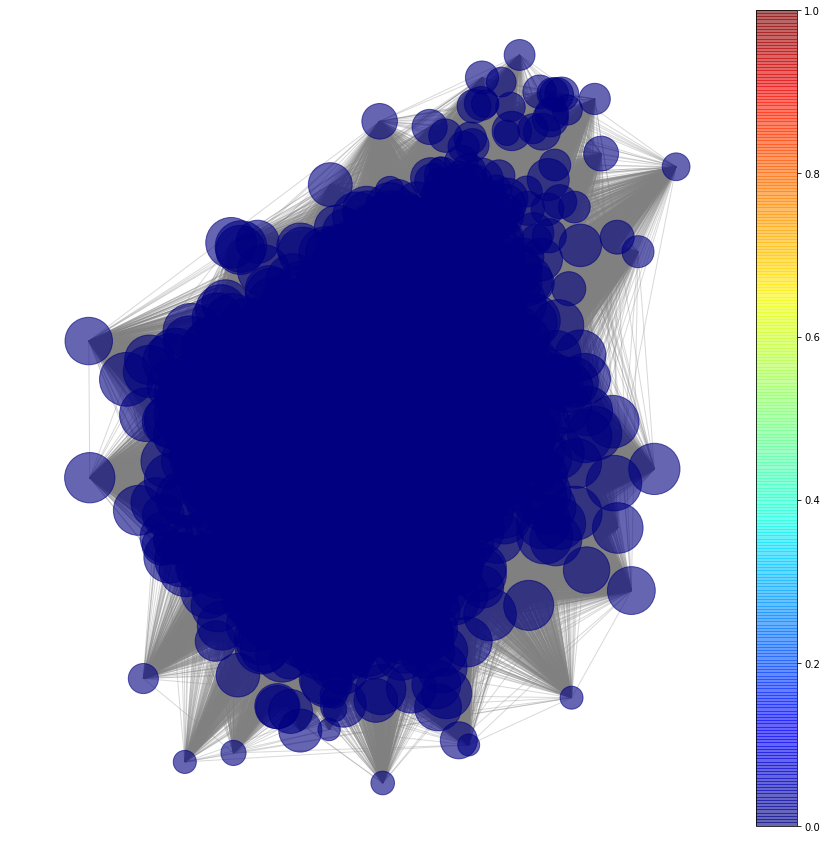

In [16]:
node_color = [0.0 for node in grafo.nodes()]
node_size = [grafo.degree(node) for node in grafo.nodes()]
plt.figure(figsize=(15,15))
ed = nx.draw_networkx_edges(grafo, pos=pos, alpha=0.3, edge_color='gray')
no = nx.draw_networkx_nodes(grafo, pos=pos, alpha=0.6, with_labels=False, node_color=node_color, 
                            cmap=cm.jet, vmin=0.0, vmax=1.0,
                            node_size=node_size)
plt.colorbar(no)
plt.axis('off')

(-0.6874071192462089,
 0.7203559465818836,
 -0.9431934084852313,
 1.1123642258061126)

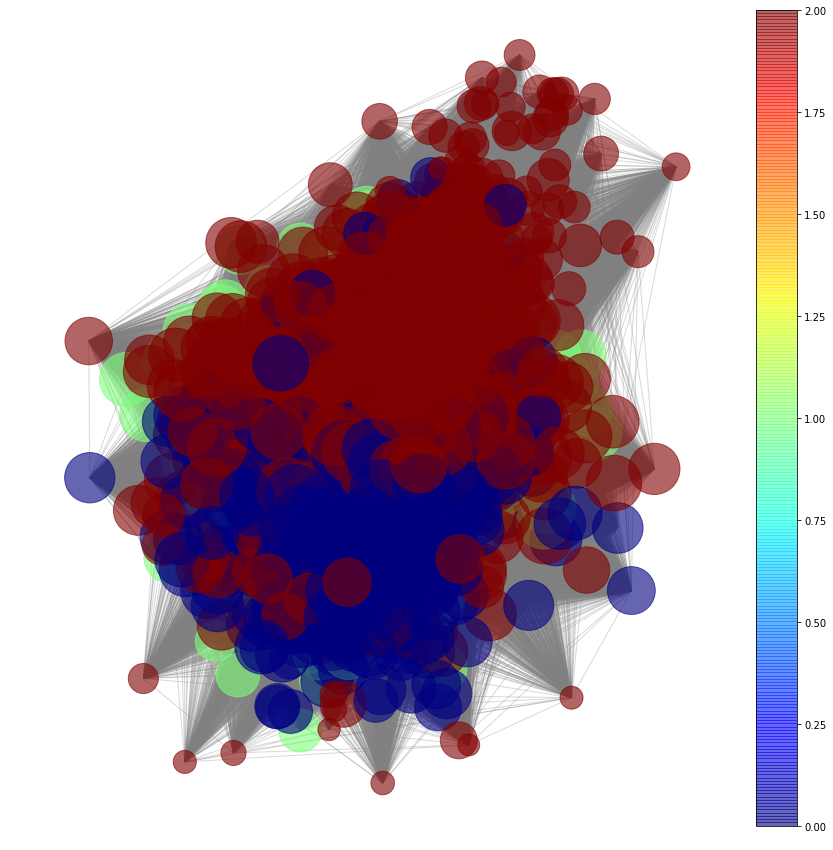

In [17]:
partition = community.best_partition(grafo, weight='weight')
node_color = [partition.get(node) for node in grafo.nodes()]
node_size = [grafo.degree(node) for node in grafo.nodes()]
plt.figure(figsize=(15,15))
ed = nx.draw_networkx_edges(grafo, pos=pos, alpha=0.3, edge_color='gray')
no = nx.draw_networkx_nodes(grafo, pos=pos, alpha=0.6, with_labels=False, node_color=node_color, 
                            cmap=cm.jet, vmin=0.0, vmax=max(partition.values()),
                            node_size=node_size)
plt.colorbar(no)
plt.axis('off')

In [49]:
likes_completo['cluster'] = likes_completo['id'].apply(
    lambda x: partition[str(x)] if str(x) in list(partition.keys()) else None)

In [50]:
likes_com_cluster = likes_completo[~likes_completo['cluster'].isnull()]

In [51]:
likes_com_cluster.head()

,id,firstName,gender,avenue_id,avenue_name,avenue_categories,avenue_lat,avenue_lng,cluster
1,484503812,Fer,male,4c531929479fc9282b90ee90,Central Park West - W 86th St,Park,40.785417,-73.969519,0.0
2,6532455,Sarah,female,4c531929479fc9282b90ee90,Central Park West - W 86th St,Park,40.785417,-73.969519,1.0
4,325835336,Rodrigo,male,4c531929479fc9282b90ee90,Central Park West - W 86th St,Park,40.785417,-73.969519,1.0
8,3151862,Susan,female,4c531929479fc9282b90ee90,Central Park West - W 86th St,Park,40.785417,-73.969519,1.0
9,33481755,Adalberto Luiz,male,4c531929479fc9282b90ee90,Central Park West - W 86th St,Park,40.785417,-73.969519,1.0


In [52]:
likes_com_cluster[likes_com_cluster['cluster'] == 0]['avenue_name'].value_counts()[:5]

Rockefeller Center                                             1043
Empire State Building                                           733
American Museum of Natural History                              678
Top of the Rock Observation Deck                                670
The Metropolitan Museum of Art (Metropolitan Museum of Art)     653
Name: avenue_name, dtype: int64

In [53]:
likes_com_cluster[likes_com_cluster['cluster'] == 1]['avenue_name'].value_counts()[:5]

Central Park                                                   1181
Bryant Park                                                     667
The Metropolitan Museum of Art (Metropolitan Museum of Art)     589
Museum of Modern Art (MoMA)                                     433
Madison Square Park                                             420
Name: avenue_name, dtype: int64

In [54]:
likes_com_cluster[likes_com_cluster['cluster'] == 2]['avenue_name'].value_counts()[:5]

Bryant Park                                                    837
Eataly                                                         761
The Metropolitan Museum of Art (Metropolitan Museum of Art)    737
Madison Square Park                                            659
Museum of Modern Art (MoMA)                                    596
Name: avenue_name, dtype: int64